![dssg_banner](assets/dssg_banner.png)

## Getting Started

### Optional: Set up Google Colab environment

If you work in your local IDE and installed the packages and requirements on your own machine, you can skip this section and start from the import section.
Otherwise you can follow and execute this notebook in your browser. For this, click on the button below to open this page in the Colab environment.

<a href="https://colab.research.google.com/github/DSSGxMunich/land-sealing-dataset-and-analysis/blob/main/src/1_execute_pipeline.ipynb" target="_parent"> <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Google Colab"/> </a>

Once in Colab, run the cell below to install the packages we will use.
What's important to properly set up the notebook:

1. Warning: This notebook was not authored by Google. Click on 'Run anyway'.
2. When the installation commands are done, there might be "Restart runtime" button at the end of the output. Please, *click* it. 

In [ ]:
# %pip install json

By running the next cell you are going to create a folder in your Google Drive. All the files for this tutorial will be uploaded to this folder. After the first execution you might receive some warning and notification, please follow these instructions:
1. Permit this notebook to access your Google Drive files? *Click* on 'Yes', and select your account.
2. Google Drive for desktop wants to access your Google Account. *Click* on 'Allow'.

At this point, a folder has been created and you can navigate it through the lefthand panel in Colab, you might also have received an email that informs you about the access on your Google Drive. 

In [ ]:
# Create a folder in your Google Drive
# from google.colab import drive                                                                          
# drive.mount('/content/drive')

In [ ]:
# Don't run this cell if you already cloned the repo 
# !git clone https://github.com/DSSGxMunich/land-sealing-dataset-and-analysis.git

In [ ]:
# %cd land-sealing-dataset-and-analysis

## Imports

In [ ]:
import pandas as pd
import json

from data_pipeline.match_RPlan_BPlan.matching_plans import merge_rp_bp
from data_pipeline.match_RPlan_BPlan.matching_plans import export_merged_bp_rp
from data_pipeline.nrw_pdf_downloader.geojson_parser import parse_geojson
from data_pipeline.nrw_pdf_downloader.nrw_pdf_scraper import run_pdf_downloader
from data_pipeline.pdf_scraper.tika_pdf_scraper import pdf_parser_from_folder
from features.textual_features.document_texts_creation.create_document_texts import enrich_extracts_with_metadata
from features.textual_features.keyword_search.exact_keyword_search import search_df_for_keywords
from features.textual_features.keyword_search.contextual_fuzzy_search import search_best_matches_dict

from data_pipeline.rplan_content_extraction.rplan_utils import extract_text_and_save_to_txt_files
from data_pipeline.rplan_content_extraction.rplan_content_extractor import parse_rplan_directory
from data_pipeline.rplan_content_extraction.rplan_utils import parse_result_df
from data_pipeline.rplan_content_extraction.rplan_keyword_search import rplan_exact_keyword_search
from visualizations.rplan_visualization import plot_keyword_search_results

## Prerequisites

To run this notebook, you require two geojson files: one containing links to downloadable building plan pdf and one with corresponding geographical information from the regions matching each land parcel. Both files should be saved in an order corresponding to the folder structure you see in the file path below (or adjust the file path).

# Execution Pipeline

In [ ]:
INPUT_BP_FILE_PATH = '../data/nrw/bplan/raw/links/NRW_BP.geojson'
INPUT_REGIONS_FILE_PATH = '../data/nrw/rplan/raw/geo/regions_map.geojson'

BP_PDF_DIR = '../data/nrw/bplan/raw/pdfs'
BP_CSV_FILE_PATH = '../data/nrw/bplan/raw/links/NRW_BP_parsed_links.csv'
LAND_PARCELS_FILE_PATH = '../data/nrw/bplan/raw/links/land_parcels.geojson'

BP_TEXT_FILE_PATH_JSON = '../data/nrw/bplan/raw/text/bp_text.json' 

RPLAN_PDF_DIR = "../data/nrw/rplan/raw/pdfs"
RPLAN_TXT_DIR = "../data/nrw/rplan/raw/text"
RPLAN_OUTPUT_PATH = "../data/nrw/rplan/features/regional_plan_sections.json"
RPLAN_KEYWORDS_PATH = "../data/nrw/rplan/features/rplan_keywords.json"

DOCUMENT_TEXT_FILE_PATH_JSON = '../data/nrw/bplan/raw/text/document_texts.json'

EXACT_KEYWORD_DICT_FILEPATHS = {
    'features/textual_features/keyword_search/keyword_dict_baunvo.json':
    '../data/nrw/bplan/features/keywords/exact_search/baunvo_keywords.csv'
    }
"""key: keyword dict path, value: output csv path"""

HOCHWASSER_KEYWORD_DICT_FILEPATH = 'features/textual_features/keyword_search/keyword_dict_hochwasser.json'
HOCHWASSER_FUZZY_SEARCH_FILE_PATH_CSV = '../data/nrw/bplan/features/keywords/fuzzy_search/keyword_dict_hochwasser.csv'
HOCHWASSER_FUZZY_SEARCH_FILE_PATH_JSON = '../data/nrw/bplan/features/keywords/fuzzy_search/keyword_dict_hochwasser.json'

DOCUMENT_ID_COLUMN='filename'
TEXT_COLUMN='content'
METADATA_COLUMNS = 'metadata'

## Step 1: Scrape building plans from NRW geoportal
The basis for this scrape is a data set with links to building plans in pdf format (`scanurl`) and further metadata per building plan provided in the [NRW geoportal](https://www.geoportal.nrw/?activetab=map), also made available in this repository (`'../data/nrw/bplan/raw/links/NRW_BP.geojson'`). The information from this file is parsed, relevant links and further information are extracted and the PDF files are then downloaded.

In [ ]:
# Parse geojson
parsed_geojson = parse_geojson(file_path=INPUT_BP_FILE_PATH,
                               output_path = BP_CSV_FILE_PATH)

In [ ]:
parsed_geojson = pd.read_csv(BP_CSV_FILE_PATH)
print(parsed_geojson.shape)
# Run downloader
run_pdf_downloader(input_df=parsed_geojson,
                   output_folder=BP_PDF_DIR)

To create the data table `land_parcels`, we add columns that refer to the regional plan corresponding to each development plan. It takes as input the same geojson (`INPUT_BP_FILE_PATH)` we were working with before, but also the file that contains geodata of the regions (provided by GreenDIA and also in this repository).

In [ ]:
land_parcels = merge_rp_bp(INPUT_BP_FILE_PATH, INPUT_REGIONS_FILE_PATH)

In [ ]:
export_merged_bp_rp(LAND_PARCELS_FILE_PATH, INPUT_BP_FILE_PATH, INPUT_REGIONS_FILE_PATH)

In [ ]:
# Clearing memory before new executions
del parsed_geojson
del land_parcels

## Step 2: Extract text from PDFs
In which we apply OCR to extract the text from each document scraped from the NRW building plan portal. 

In [ ]:
parsed_pdfs_df = pdf_parser_from_folder(folder_path=BP_PDF_DIR)

parsed_pdfs_json = parsed_pdfs_df.to_json(orient='records')

with open(BP_TEXT_FILE_PATH_JSON, 'w') as outputfile:
    outputfile.write(parsed_pdfs_json)

In [ ]:
del parsed_pdfs_df
del parsed_pdfs_json

## Step 3: Enrich extracted building plan texts with information about corresponding land parcels

To ultimately create the data table `document_texts`

In [ ]:
bplans_info = pd.read_csv(BP_CSV_FILE_PATH, dtype='unicode')
bplans_text = pd.read_json(BP_TEXT_FILE_PATH_JSON)

result_df = enrich_extracts_with_metadata(info_df=bplans_info,
                                          text_df=bplans_text)

In [ ]:
bp_parsed_links = pd.read_csv('../data/nrw/bplan/raw/links/NRW_BP_parsed_links.csv')


In [ ]:
bplans_info['plantyp'].unique()

In [ ]:
# write results to json
result_json = result_df.to_json(orient='records')
with open(DOCUMENT_TEXT_FILE_PATH_JSON, 'w') as outputfile:
    outputfile.write(result_json)

In [ ]:
# Clearing memory
del result_df

## Step 4: Perform an exact keyword search in extracted texts

In [ ]:
# read in data
bp_text_df = pd.read_json(BP_TEXT_FILE_PATH_JSON)

In [ ]:

for keyword_dict_file_path in EXACT_KEYWORD_DICT_FILEPATHS.keys():
    with open(keyword_dict_file_path) as f:
        keywords_dict= json.load(f) 
        
    result_df = search_df_for_keywords(input_df=bp_text_df,
                                   text_column_name=TEXT_COLUMN,
                                   id_column_name=DOCUMENT_ID_COLUMN,
                                   keyword_dict=keywords_dict)
    
    result_df.to_csv(EXACT_KEYWORD_DICT_FILEPATHS[keyword_dict_file_path], header=True, index=False)


In [ ]:
del result_df

## Step 5: Perform an fuzzy keyword search in extracted texts

In [ ]:
! python features/textual_features/keyword_search/contextual_fuzzy_search_parallelised.py

In [ ]:
with open(HOCHWASSER_KEYWORD_DICT_FILEPATH) as f:
    HOCHWASSER_KEYWORDS = json.load(f)
threshold=85
context_words=15
all_matches = search_best_matches_dict(input_df=bp_text_df,
                                         id_column_name=DOCUMENT_ID_COLUMN,
                                         text_column_name=TEXT_COLUMN,
                                         keyword_dict=HOCHWASSER_KEYWORDS,
                                         threshold=threshold,
                                         context_words=context_words)

In [ ]:
all_matches

In [ ]:
all_matches_json = all_matches.to_json(orient='records')
with open(HOCHWASSER_FUZZY_SEARCH_FILE_PATH_JSON, 'w') as outputfile:
    outputfile.write(all_matches_json)

## Step 6: Extract content from regional plans

To extract content from regional plans, i.e. parse the text from the pdfs and divide them into chapters / sections. This yields the `regional_plan_sections` dataset.

In [25]:
extract_text_and_save_to_txt_files(pdf_dir_path=RPLAN_PDF_DIR,
                                   txt_dir_path=RPLAN_TXT_DIR)

input_df = parse_rplan_directory(txt_dir_path=RPLAN_TXT_DIR,
                                 json_output_path=RPLAN_OUTPUT_PATH)

input_df = parse_result_df(df=input_df)
# save to json
input_df.to_json(RPLAN_OUTPUT_PATH)

2023-09-25 19:39:11.052 | DEBUG    | data_pipeline.rplan_content_extraction.rplan_content_extractor:parse_rplan_directory:341 - ../data/nrw/rplan/raw/text/muenster-2004.txt
2023-09-25 19:39:11.053 | DEBUG    | data_pipeline.rplan_content_extraction.rplan_content_extractor:parse_rplan_directory:343 - Processing file ../data/nrw/rplan/raw/text/muenster-2004.txt
2023-09-25 19:39:11.466 | DEBUG    | data_pipeline.rplan_content_extraction.rplan_content_extractor:parse_rplan_directory:341 - ../data/nrw/rplan/raw/text/bielefeld-_.txt
2023-09-25 19:39:11.467 | DEBUG    | data_pipeline.rplan_content_extraction.rplan_content_extractor:parse_rplan_directory:343 - Processing file ../data/nrw/rplan/raw/text/bielefeld-_.txt
2023-09-25 19:39:11.681 | DEBUG    | data_pipeline.rplan_content_extraction.rplan_content_extractor:parse_rplan_directory:341 - ../data/nrw/rplan/raw/text/arnsberg-2008-siegen.txt
2023-09-25 19:39:11.681 | DEBUG    | data_pipeline.rplan_content_extraction.rplan_content_extractor:

## Step 7: Perform an exact keyword search in extracted texts of regional plans

In [26]:
exact_result,exact_keywords = rplan_exact_keyword_search(input_df=input_df, save_path=RPLAN_KEYWORDS_PATH)

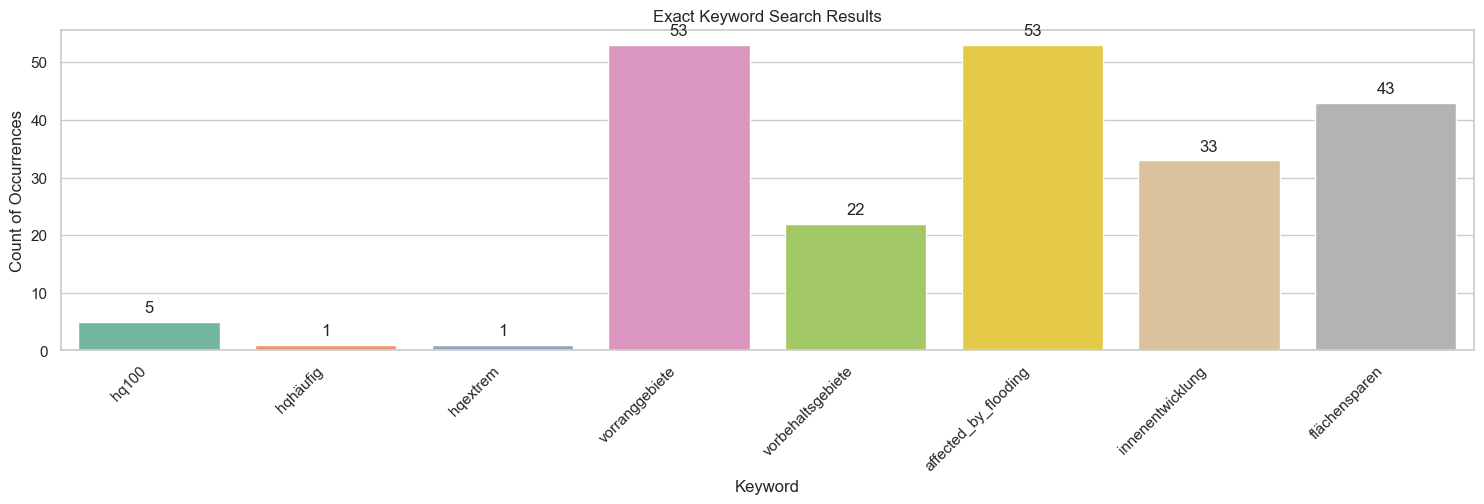

In [27]:
plot_keyword_search_results(result_df=exact_result,
                            keyword_columns=exact_keywords,
                            title="Exact Keyword Search Results")

In [ ]:
del input_df, exact_result, exact_keywords

## Conclusion
This notebook provides the code to execute the pipeline which populates the land sealing dataset.
Further work is done by 'knowledge_agent.ipynb' which produces data using ChatGPT. Note that this shall require a ChatGPT API key of your own. 

The 'explorer.ipynb' demonstrates functions which display and explore the complete data set. 
